In [1]:
import importlib
import pydicom as dicom

import pickle
import data
import models
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import matplotlib.pylab as plt
from PIL import Image
import numpy as np
import cv2

importlib.reload(data)
importlib.reload(models)

<module 'models' from '/Users/amolmenon/Documents/Spring 2023/CMSC472/cmsc472_medicaldiagnosis/models.py'>

In [2]:
all_data = data.load_datasets()

train_set = all_data['lung']['train']
val_set = all_data['lung']['val']

In [3]:
batch_size = 16
learning_rate = 0.0005
epochs = 10

In [4]:
train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

In [5]:
model = models.get_model_class('lung')
optim = torch.optim.SGD(model.parameters(), lr = learning_rate) 
loss_function = nn.BCELoss() 

In [6]:
torch.manual_seed(42)


train_loss_epochs = []
val_loss_epochs = []
train_accs_epochs = []
val_accs_epochs = []


for epoch in range(epochs):

    #Training phase
    model.train()  #Setting the model to train phase
    train_loss = []
    val_loss = []

    train_accs = []
    val_accs = []

    for idx, batch in enumerate(train_dataloader):

        x = batch[0].unsqueeze(1)
        x = x
        y = batch[1]

        optim.zero_grad()

        out = model(x)

        loss = loss_function(out, y.float().unsqueeze(1))
        loss.backward()
        optim.step()


        y_pred = torch.round(out)

        train_acc = torch.sum(torch.square(torch.sub(y, y_pred))).item() / (y.size(dim=0))
        train_acc = (torch.squeeze(y_pred).eq(y)).sum().item() / y.size(dim=0)
        
        train_accs.append(train_acc)
        train_loss.append(loss.item())


    #Validation phase
    model.eval()  #Setting the model to eval mode, hence making it deterministic.
    for idx, batch in enumerate(val_dataloader):
        with torch.no_grad():   #Does not calulate the graidents, as in val phase its not needed. Saves on memory.
            x = batch[0].unsqueeze(1)
            y = batch[1]
            out = model.forward(x)
            loss = loss_function(out, y.float().unsqueeze(1))
            y_pred = torch.round(out)
            val_acc = (torch.squeeze(y_pred).eq(y)).sum().item() / y.size(dim=0)
            
            val_loss.append(loss.item())
            val_accs.append(val_acc)
    train_loss_epochs.append(np.mean(train_loss))
    val_loss_epochs.append(np.mean(val_loss))
    train_accs_epochs.append(np.mean(train_accs))
    val_accs_epochs.append(np.mean(val_accs))
    if epoch%1==0:
        print("Epoch : {}, Train loss: {:.5f} , Train Acc: {:.4f}, Val loss: {:.5f}, Val acc: {:.4f}".format(epoch, np.mean(train_loss), np.mean(train_acc), np.mean(val_loss), np.mean(val_acc)))
        
        

Epoch : 0, Train loss: 0.67242 , Train Acc: 1.0000, Val loss: 0.67753, Val acc: 1.0000
Epoch : 1, Train loss: 0.56578 , Train Acc: 1.0000, Val loss: 0.65299, Val acc: 1.0000
Epoch : 2, Train loss: 0.50960 , Train Acc: 1.0000, Val loss: 0.64018, Val acc: 0.7500
Epoch : 3, Train loss: 0.47026 , Train Acc: 0.6667, Val loss: 0.62176, Val acc: 0.7500
Epoch : 4, Train loss: 0.43873 , Train Acc: 0.6667, Val loss: 0.60568, Val acc: 0.7500
Epoch : 5, Train loss: 0.37388 , Train Acc: 1.0000, Val loss: 0.61066, Val acc: 0.7500
Epoch : 6, Train loss: 0.36187 , Train Acc: 1.0000, Val loss: 0.59944, Val acc: 0.7500
Epoch : 7, Train loss: 0.32192 , Train Acc: 1.0000, Val loss: 0.59973, Val acc: 0.7500
Epoch : 8, Train loss: 0.30870 , Train Acc: 1.0000, Val loss: 0.61228, Val acc: 0.7500
Epoch : 9, Train loss: 0.27782 , Train Acc: 1.0000, Val loss: 0.60387, Val acc: 0.7500


In [7]:
with open(f'./trained_models/meta_lung.pkl', 'wb') as f:
    pickle.dump(model, f)

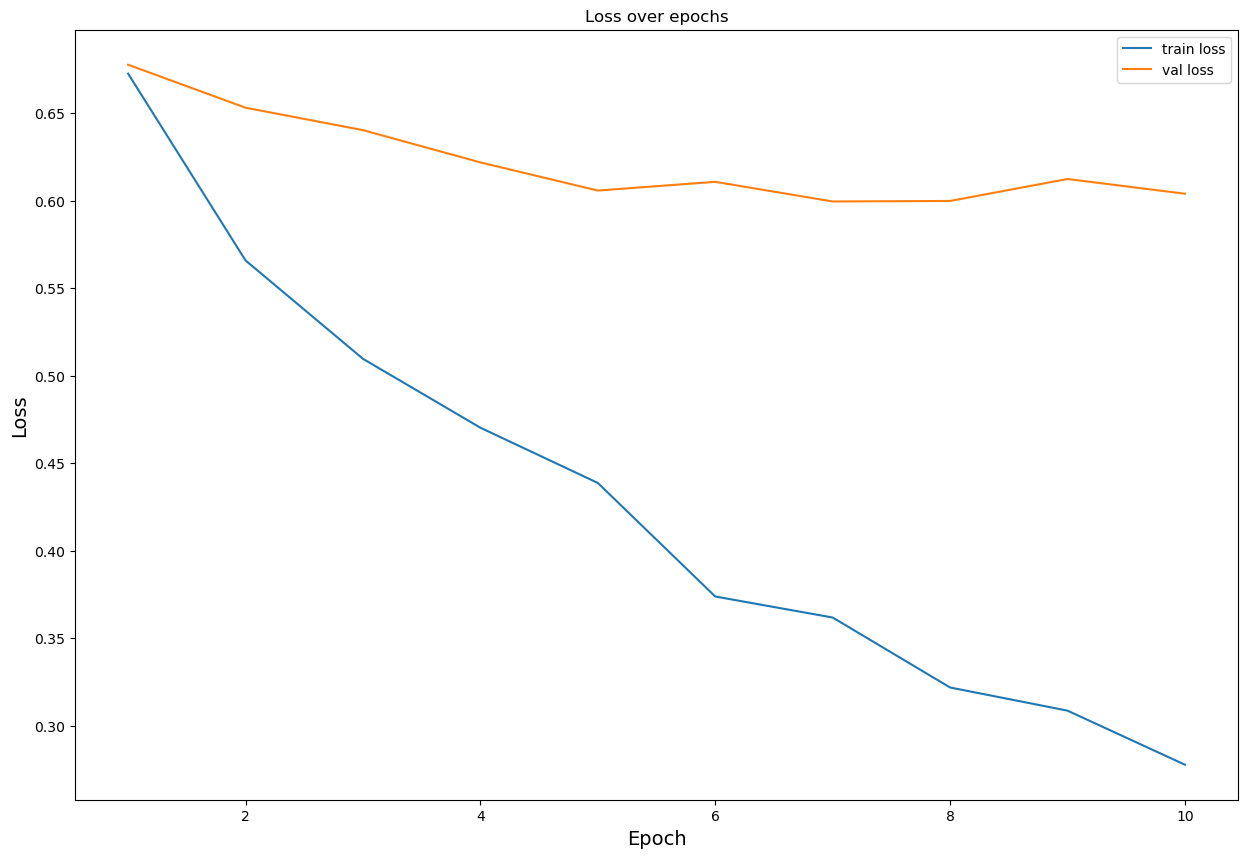

In [8]:
plt.figure(figsize=(15, 10))
plt.plot(range(1, epochs+1), train_loss_epochs, label='train loss')
plt.plot(range(1, epochs+1), val_loss_epochs, label='val loss')
plt.xlabel("Epoch", size=14)
plt.ylabel("Loss", size=14)
plt.title("Loss over epochs")
plt.legend()
plt.show()

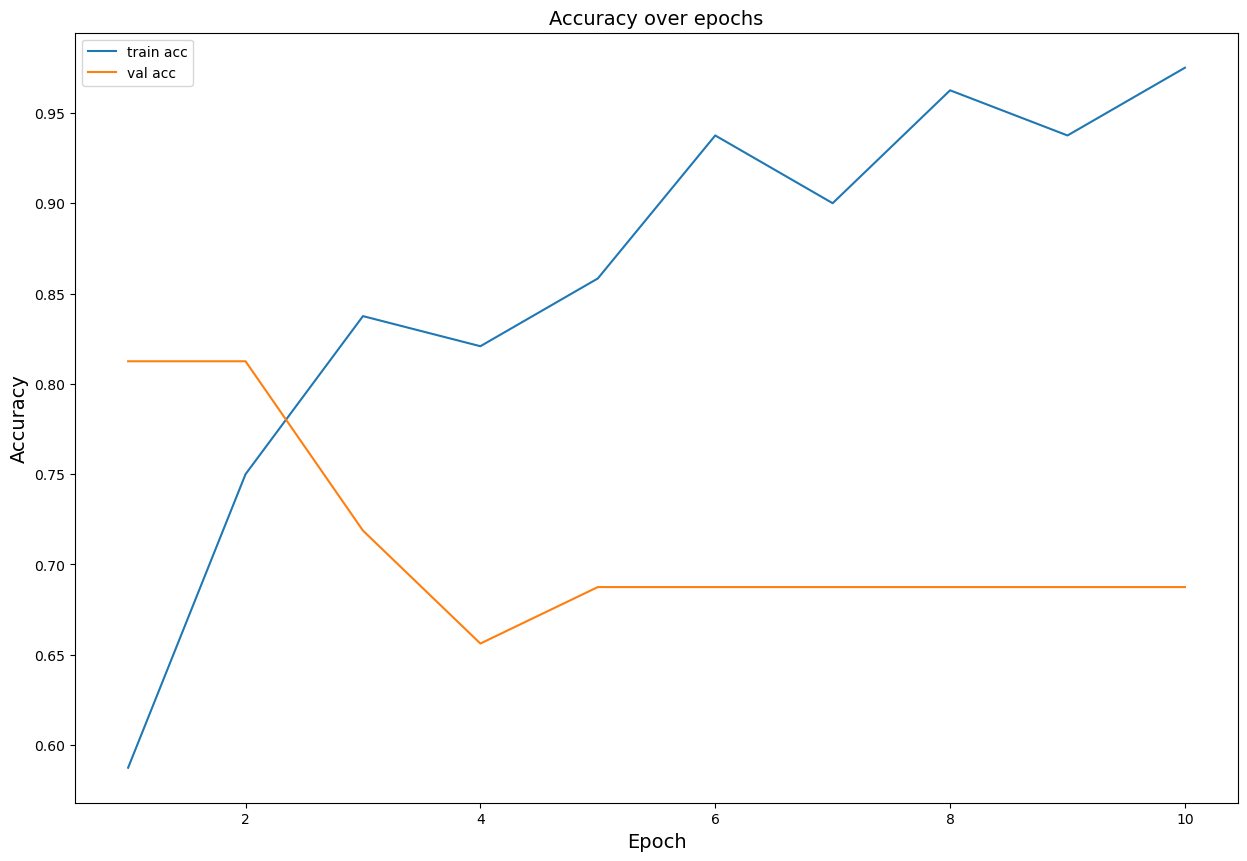

In [9]:
plt.figure(figsize=(15, 10))
plt.plot(range(1, epochs+1), train_accs_epochs, label='train acc')
plt.plot(range(1,epochs+1), val_accs_epochs, label='val acc')
plt.xlabel("Epoch", size=14)
plt.ylabel("Accuracy", size=14)
plt.title("Accuracy over epochs", size=14)
plt.legend()
plt.show()

In [10]:
torch.save(model.state_dict(), './trained_models/lung_meta_weights.pth')
with open('./trained_models/lung_model_class.pkl', 'wb') as f:
    pickle.dump(model, f)

1


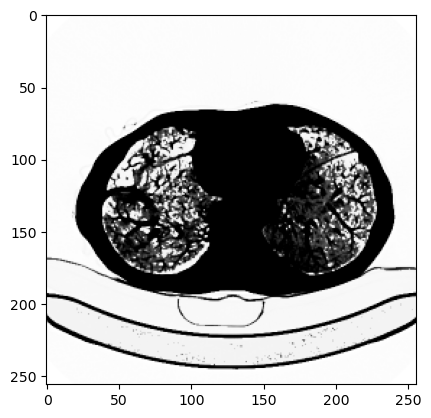

In [11]:
i = 17
plt.imshow(train_set[i][0], cmap='Greys')
print(train_set[i][1].item())